In [18]:
pip install pandas 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER PC\AppData\Local\Programs\Python\Python314\python.exe -m pip install --upgrade pip


In [132]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\USER PC\AppData\Local\Programs\Python\Python314\python.exe -m pip install --upgrade pip


In [133]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
# 1. LOAD DATA
# =========================================================
df = pd.read_csv(r"WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [135]:
#data cleaninig+ EDA
# Convert TotalCharges to numeric (some values are blank)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"]

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

In [136]:
# Handle missing values
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

In [137]:
# Drop customerID (not useful)
df = df.drop("customerID", axis=1)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [161]:
df['Churn'] = df['Churn'].replace({'Yes':1, 'No':0})

In [162]:
df['Churn'] = df['Churn'].fillna(0)   # أو يمكنك حذف الصفوف بدلًا من ملء القيم

In [163]:
# 3. SPLIT FEATURES & LABEL
# -----------------------------
X = df.drop("Churn", axis=1)
y = df["Churn"]
X
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7021, dtype: int64

In [165]:
# Remove duplicates
df = df.drop_duplicates()
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,False,False,False,True,False,False,False
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,True,False,False,False,True,False,False
2,1,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,False,False,False,False,True,False,False
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,True,False,False,False,False,False,False
4,0,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,...,84.80,1990.50,0,True,False,False,False,True,False,False
7039,0,0,1,1,72,1,1,0,1,1,...,103.20,7362.90,0,True,False,True,False,False,True,False
7040,0,0,1,1,11,0,0,1,0,0,...,29.60,346.45,0,False,False,False,True,False,False,False
7041,1,1,1,0,4,1,1,0,0,0,...,74.40,306.60,1,False,False,False,False,True,True,False


In [141]:
# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())


C:\Users\USER PC\AppData\Local\Temp\ipykernel_7600\3594960690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
C:\Users\USER PC\AppData\Local\Temp\ipykernel_7600\3594960690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())


In [142]:
# 4. ENCODING
# -----------------------------
#Label Encoding
encoder = LabelEncoder()
df['gender'] = encoder.fit_transform(df['gender'])

#Binary Mapping (Yes/No → 1/0)
replace_map = {
    'Yes': 1,
    'No': 0,
    'No phone service': 0,
    'No internet service': 0
}

binary_cols = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn',
               'MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection',
               'TechSupport','StreamingTV','StreamingMovies']

for col in binary_cols:
    df[col] = df[col].replace(replace_map)

#One-Hot Encoding
df = pd.get_dummies(df, columns=['Contract','PaymentMethod','InternetService'], drop_first=True)



# Separate categorical & numeric columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Final pipeline
model_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])




C:\Users\USER PC\AppData\Local\Temp\ipykernel_7600\3538906447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender'] = encoder.fit_transform(df['gender'])
C:\Users\USER PC\AppData\Local\Temp\ipykernel_7600\3538906447.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(replace_map)
C:\Users\USER PC\AppData\Local\Temp\ipykernel_7600\3538906447.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [148]:
# 1. BASIC OVERVIEW
# ------------------------------

print("\n--- DATA INFO ---")
print(df.info())
print("\n--- MISSING VALUES ---")
print(df.isnull().sum())
print("\n--- STATISTICS ---")
print(df.describe())


--- DATA INFO ---
<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7021 non-null   int64  
 1   SeniorCitizen                          7021 non-null   int64  
 2   Partner                                7021 non-null   int64  
 3   Dependents                             7021 non-null   int64  
 4   tenure                                 7021 non-null   int64  
 5   PhoneService                           7021 non-null   int64  
 6   MultipleLines                          7021 non-null   int64  
 7   OnlineSecurity                         7021 non-null   int64  
 8   OnlineBackup                           7021 non-null   int64  
 9   DeviceProtection                       7021 non-null   int64  
 10  TechSupport                            7021 non-null   int

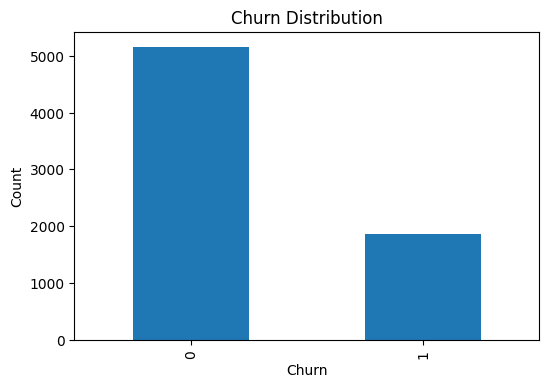

In [149]:
# 2. CHURN DISTRIBUTION
# ------------------------------

plt.figure(figsize=(6,4))
df["Churn"].value_counts().plot(kind="bar")
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


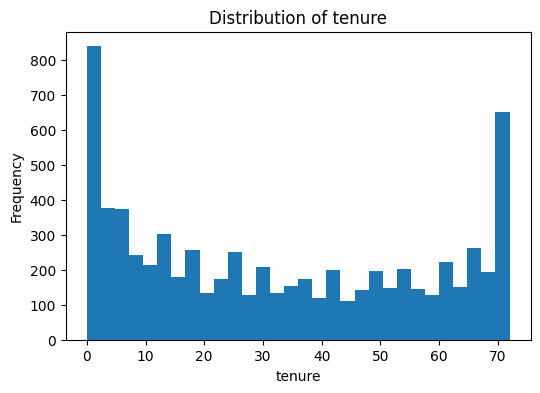

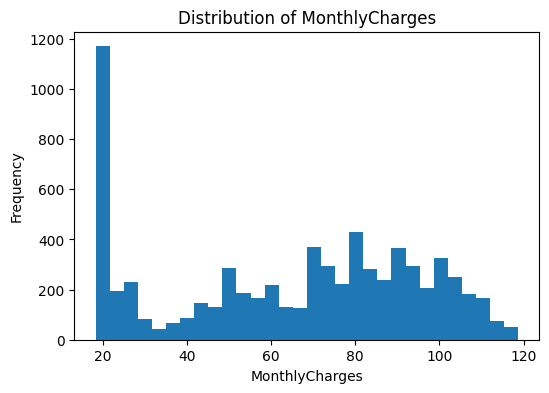

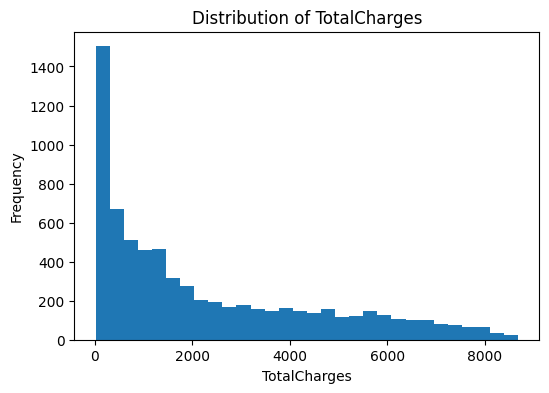

In [150]:
# 3. NUMERIC DISTRIBUTIONS
# ------------------------------

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


<Figure size 600x400 with 0 Axes>

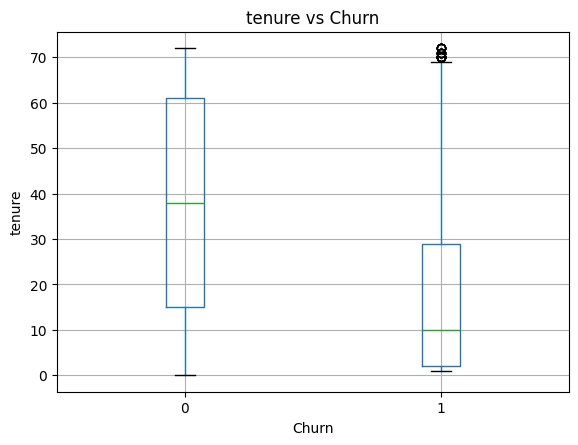

<Figure size 600x400 with 0 Axes>

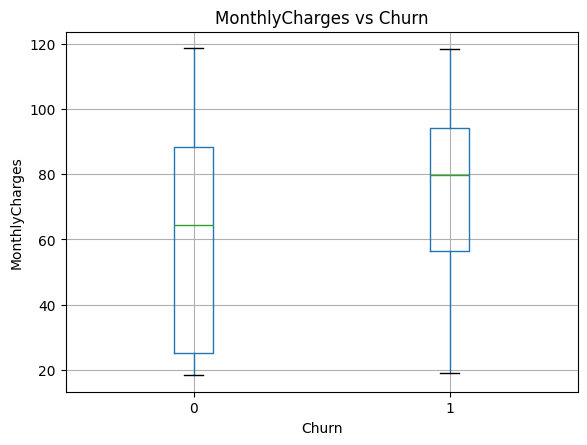

<Figure size 600x400 with 0 Axes>

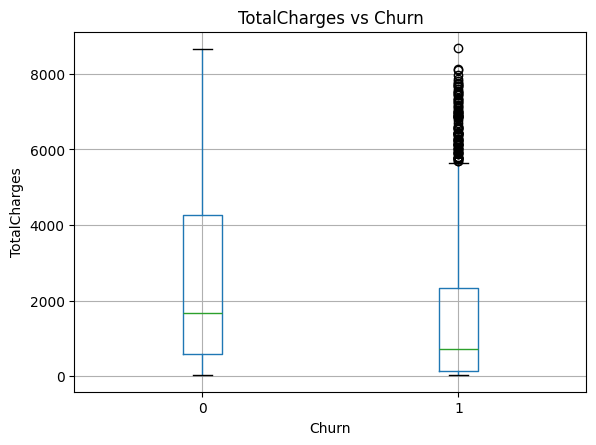

In [151]:
# 4. CHURN VS NUMERIC FEATURES
# ------------------------------

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    df.boxplot(column=col, by="Churn")
    plt.title(f"{col} vs Churn")
    plt.suptitle("")
    plt.xlabel("Churn")
    plt.ylabel(col)
    plt.show()


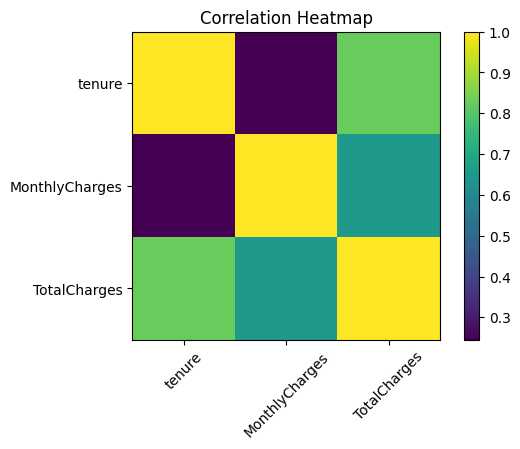

In [171]:
# 6. CORRELATION HEATMAP (NUMERIC)
# ------------------------------

plt.figure(figsize=(6,4))
corr = df[numeric_cols].corr()
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Heatmap")
plt.show()

In [173]:
#feature Engineering:


<Axes: >

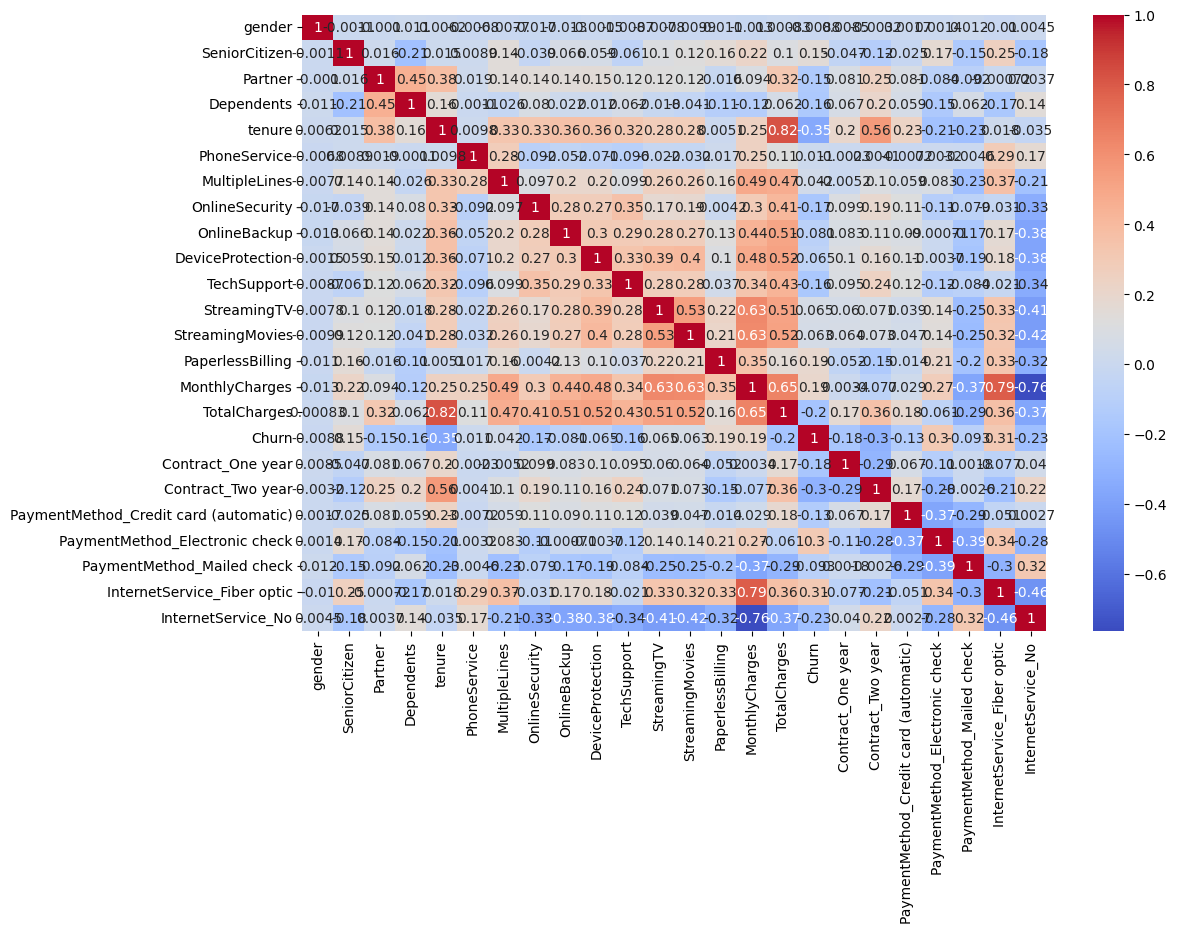

In [154]:

#feature selection : Regression

corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [176]:
# 5. TRAIN/TEST SPLIT
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the pipeline on training data
X_train_processed = model_pipeline.fit_transform(X_train)
X_test_processed = model_pipeline.transform(X_test)

print("Preprocessing Completed Successfully!")
print("Training set shape:", X_train_processed.shape)
print("Testing  set shape:", X_test_processed.shape)

ValueError: A given column is not a column of the dataframe

In [178]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

# إنشاء النموذج مع قيمة alpha (قوة العقوبة)
ridge = Ridge(alpha=1.0)

# تدريب النموذج
ridge.fit(X_train, y_train)

# التنبؤ
y_pred = ridge.predict(X_test)

# تحويل التنبؤات إلى 0/1 (لأن الهدف هو churn)
y_pred_class = (y_pred >= 0.5).astype(int)

# تقييم النموذج
print("Accuracy:", accuracy_score(y_test, y_pred_class))

Accuracy: 0.804982206405694
